# Introduction

In this notebook, we will practice using **PyTorch** to create **convolutional neural networks** (CNNs). We will be training a **CNN** for the **MNIST digit classification** task.

1. Prepare the data (dataset & dataloader)
2. Construct the model
3. Define the loss and optimiser
4. Write a training loop

**Libraries**

In [1]:
# Core
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
sns.set(style='darkgrid', font_scale=1.4)
import matplotlib.pyplot as plt
%matplotlib inline
import random

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

**Reproducibility**

In [2]:
# Random seeds
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
set_seed()

**Config**

In [3]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
N_EPOCHS = 60

# Network dims
CONV1_CHANNELS = 64
CONV2_CHANNELS = 128
LINEAR1_SIZE = 256
LINEAR2_SIZE = 128
DROPOUT_RATE = 0.35

Connect to **GPU** if available, otherwise use the **CPU**.

In [4]:
# Config device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

To use the **device**, in general we need to send the **model**, **features** and **labels** to the device.
1. `model.to(device)`
2. `features = features.to(device)`
3. `labels = labels.to(device)`

# Data

**Load data**

In [5]:
# Training data
train_data=pd.read_csv('../input/digit-recognizer/train.csv')

# Test data scaled to lie in [0,1]
test_data=pd.read_csv('../input/digit-recognizer/test.csv')/255

# Shape and preview
print(train_data.shape)
train_data.head(3)

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Check for null values**

In [6]:
print('Number of null values in training set:',train_data.isnull().sum().sum())
print('')
print('Number of null values in test set:',test_data.isnull().sum().sum())

Number of null values in training set: 0

Number of null values in test set: 0


**Preview first few images**

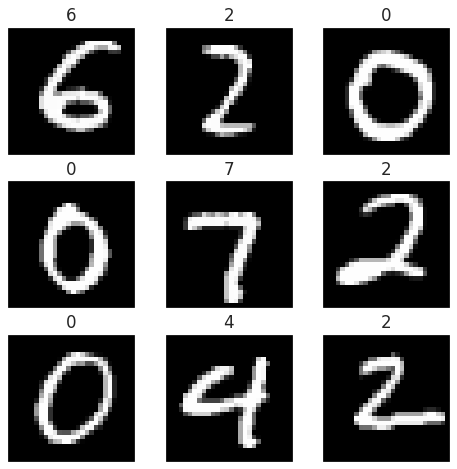

In [7]:
# Figure size
plt.figure(figsize=(8,8))

# Subplot
for i in range(9):
    img = np.asarray(train_data.iloc[i+270,1:].values.reshape((28,28))/255)
    ax=plt.subplot(3, 3, i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text(f'{train_data.iloc[i+270,0]}')
    plt.imshow(img, cmap='gray')
    
plt.show()

**Explore label distribution**

Text(0.5, 1.0, 'Distribution of labels in training set')

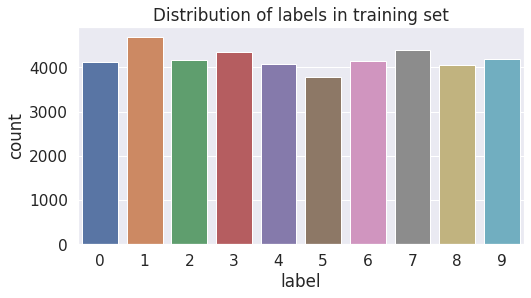

In [8]:
# Countplot
plt.figure(figsize=(8,4))
sns.countplot(x='label', data=train_data)
plt.title('Distribution of labels in training set')

**Labels and features**

In [9]:
# Labels
y = train_data.label

# Features scaled to lie in [0,1]
X = train_data.drop('label', axis=1)/255

**Reshape data**

In [10]:
# Reshape (-1 means unspecified)
X = X.values.reshape(-1, 1, 28, 28)

# Save test data index for submission
test_index = test_data.index

# Reshape
test_data = test_data.values.reshape(-1, 1, 28, 28)

**Break off validation set**

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.9, test_size=0.1, random_state=0)

**Data augmentation**

Data augmentation is a **clever trick** that uses your existing training set to create **additional 'fake' data** by applying **small transformations** to every batch. This doesn't change the size of your training set, it just **modifies each image slightly** every batch so that the network becomes **more robust** over several epochs.

In [12]:
# Random rotation and random zoom
data_transforms = transforms.Compose([
        transforms.RandomRotation(degrees=30),
        transforms.RandomResizedCrop(size=(28,28), scale=(0.8, 1.2),ratio=(1,1)),
        ])

# Dataset & Dataloader

A **dataloader** will feed in **batches** of training examples to the model. This is especially **useful** for very **large datasets** where you can't load the whole dataset in one go. 

As input, it needs a **dataset**, which is created in a class and requires the `__init__`, `__getitem__` and `__len__` attributes.

In [13]:
# Create dataset
class MNIST(Dataset):
    # Initialise
    def __init__(self, subset='train', transform=None):
        super().__init__()
        self.subset = subset
        self.transform = transform
        
        # Store data
        if self.subset=='train':
            self.X = torch.from_numpy(X_train.astype(np.float32))
            self.y = torch.from_numpy(y_train.values)
        elif self.subset=='valid':
            self.X = torch.from_numpy(X_valid.astype(np.float32))
            self.y = torch.from_numpy(y_valid.values)
        elif self.subset=='test':
            self.X = torch.from_numpy(test_data.astype(np.float32))
        else:
            raise Exception("subset must be train, valid or test")
        
    # Get item in position given by index
    def __getitem__(self, index):
        if self.subset=='test':
            return self.X[index]
        else:
            sample = self.X[index]
            
        # Data augmentations
        if self.transform:
            sample = self.transform(sample)
    
        return sample, self.y[index]
        
    # Length of dataset 
    def __len__(self):
        return self.X.shape[0]

train_dataset = MNIST(subset='train', transform=data_transforms)
valid_dataset = MNIST(subset='valid')
test_dataset = MNIST(subset='test')

A useful feature of dataloaders is that they can **shuffle** the training set for us.

In [14]:
# Dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model

When working with **neural networks**, we need to **inherit** the `nn.Module` and define a `forward` attribute. The inheritance part is done to get access to **attributes** like `model.parameters()`, which are used in training. 

Note that we **don't** need to apply **softmax** at the end because our loss function will apply it for us.

In [15]:
# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self, conv1_channels=CONV1_CHANNELS, conv2_channels=CONV2_CHANNELS, linear1_size=LINEAR1_SIZE, linear2_size=LINEAR2_SIZE, dropout_rate=DROPOUT_RATE):
        super().__init__()
        
        # Layers
        self.conv1=nn.Conv2d(in_channels=1, out_channels=conv1_channels, kernel_size=5, stride=1, padding=2)
        self.pool=nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2=nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=3, stride=1, padding=1)
        self.flat=nn.Flatten()
        self.fc1=nn.Linear(in_features=conv2_channels*7*7, out_features=linear1_size)
        self.fc2=nn.Linear(in_features=linear1_size, out_features=linear2_size)
        self.fc3=nn.Linear(in_features=linear2_size, out_features=10)
        self.relu=nn.ReLU()
        self.drop = nn.Dropout(p=dropout_rate)
        
    def forward(self, x):
        
        # Conv block 1
        out = self.conv1(x)
        out = self.relu(out)
        out = self.pool(out)
        
        # Conv block 2
        out = self.conv2(out)
        out = self.relu(out)
        out = self.pool(out)
        
        # Fully connected layer 1
        out = self.flat(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.drop(out)
        
        # Fully connected layer 2
        out = self.fc2(out)
        out = self.relu(out)
        out = self.drop(out)
        
        # Output layer (no softmax needed)
        out = self.fc3(out)
        
        return out

model = ConvNet().to(device)

# Loss & optimiser

The **loss** function is called from the `torch.nn` library and the **optimiser** from the `torch.optim` library. Note that we need to input the model **parameters** into the optimiser.

We also use a **learning rate scheduler** to gradually reduce the learning rate over time.

In [16]:
# Cross entropy loss
loss = nn.CrossEntropyLoss()

# Adam optimiser
optimiser = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimiser, T_max=N_EPOCHS)

# Train model

The most **important** thing to remember with PyTorch is that after every epoch, you have to **zero the gradients** (otherwise they will accumulate and explode). Other than that, we need to perform the **forward pass**, **backward pass**, and **update the parameters**.

In [17]:
loss_hist = []
val_loss_hist = []

# Loop over epochs
for epoch in range(N_EPOCHS):
    loss_acc = 0
    val_loss_acc = 0
    train_count = 0
    valid_count = 0
    
    # Loop over batches
    for imgs, labels in train_loader:
        # Reshape
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward pass
        preds = model(imgs)
        L = loss(preds,labels)

        # Backprop
        L.backward()

        # Update parameters
        optimiser.step()

        # Zero gradients
        optimiser.zero_grad()
        
        # Track loss
        loss_acc += L.detach().item()
        train_count += 1
    
    # Update learning rate
    scheduler.step()
    
    # Don't update weights
    with torch.no_grad():
        # Validate
        for val_imgs, val_labels in valid_loader:
            # Reshape
            val_imgs = val_imgs.to(device)
            val_labels = val_labels.to(device)

            # Forward pass
            val_preds = model(val_imgs)
            val_L = loss(val_preds,val_labels)
            
            # Track loss
            val_loss_acc += val_L.item()
            valid_count += 1
        
    # Save loss history
    loss_hist.append(loss_acc/train_count)
    val_loss_hist.append(val_loss_acc/valid_count)
    
    # Print loss
    if (epoch+1)%10==0:
        print(f'Epoch {epoch+1}/{N_EPOCHS}, loss {loss_acc/train_count:.5f}, val_loss {val_loss_acc/valid_count:.5f}')
        
print('')
print('Training complete!')

Epoch 10/60, loss 0.06310, val_loss 0.03990
Epoch 20/60, loss 0.03973, val_loss 0.03810
Epoch 30/60, loss 0.03007, val_loss 0.03248
Epoch 40/60, loss 0.02061, val_loss 0.02952
Epoch 50/60, loss 0.01497, val_loss 0.02403
Epoch 60/60, loss 0.01334, val_loss 0.02586

Training complete!


**Learning curves**

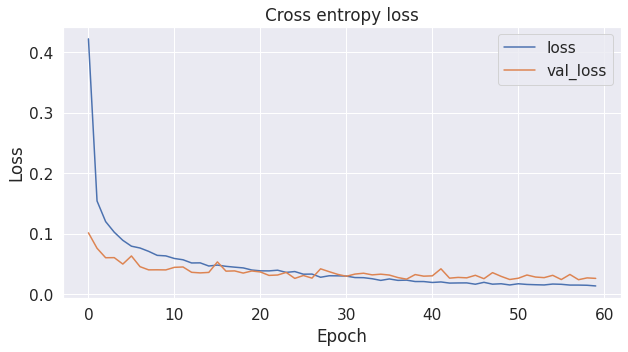

In [18]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(loss_hist, c='C0', label='loss')
plt.plot(val_loss_hist, c='C1', label='val_loss')
plt.title('Cross entropy loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate

Let's explore our model's **accuracy** on the **validation set**.

In [19]:
# Evaluation mode (turn off dropout)
model.eval()

with torch.no_grad():
    n_correct=0
    n_samples=0
    
    n_class_correct = [0 for i in range(10)]
    n_class_sample = [0 for i in range(10)]
    
    for imgs, labels in valid_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        output = model(imgs)
        
        _, preds = torch.max(output, 1)
        
        n_samples += labels.shape[0]
        n_correct += (preds == labels).sum().item()
        
        for i in range(BATCH_SIZE):
            try:
                label = labels[i].item()
                pred = preds[i].item()
            except:
                break
            
            if (label==pred):
                n_class_correct[label]+=1
            n_class_sample[label]+=1
    
    acc = 100 * n_correct/n_samples
    print(f'Overall accuracy on test set: {acc:.1f} %')
    
    for i in range(10):
        print(f'Accuracy of {i}: {100* n_class_correct[i]/n_class_sample[i]:.1f} %')

Overall accuracy on test set: 99.6 %
Accuracy of 0: 99.8 %
Accuracy of 1: 99.6 %
Accuracy of 2: 99.5 %
Accuracy of 3: 99.5 %
Accuracy of 4: 99.5 %
Accuracy of 5: 99.7 %
Accuracy of 6: 99.8 %
Accuracy of 7: 99.8 %
Accuracy of 8: 99.5 %
Accuracy of 9: 99.2 %


# Make predictions

Finally, we make predictions on the **test set**.

In [20]:
predictions = []
confidences = []

with torch.no_grad():
    for imgs in test_loader:
        imgs = imgs.to(device)
        output = model(imgs)
        
        preds = torch.argmax(output, 1)
        confs, _ = torch.max(nn.Softmax(dim=1)(output), dim=1)
        
        preds = preds.to('cpu')
        confs = confs.to('cpu')
        
        predictions.extend(preds.numpy().tolist())
        confidences.extend(confs.numpy().tolist())
        
print('')
print('Inference complete!')


Inference complete!


**Plot predictions**

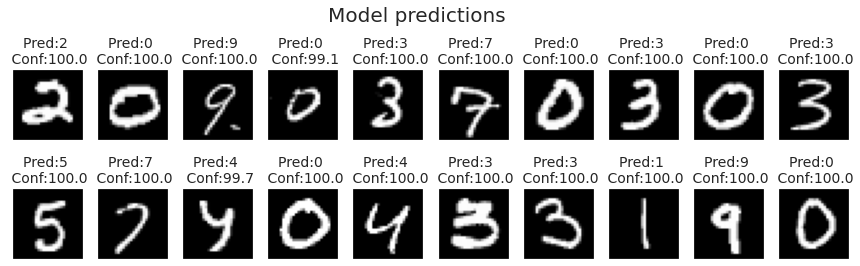

In [21]:
# Plot some model predictions
plt.figure(figsize=(15,4))
plt.suptitle('Model predictions', fontsize=20, y=1.05)

# Subplot
for i in range(20):
    img = test_data[i,0,:,:]/255
    ax=plt.subplot(2, 10, i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f'Pred:{predictions[i]} \n Conf:{np.round(100*confidences[i],1)}', fontdict = {'fontsize':14})
    plt.imshow(img, cmap='gray')
    
plt.show()

**Submit predictions**

In [22]:
# Save predictions to file
output = pd.DataFrame({'ImageId': test_index+1, 'Label': predictions})

# Check format
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [23]:
# Output to csv
output.to_csv('submission.csv', index=False)

**Check out my other PyTorch tutorials**

1. [PT1 - Linear Regression with PyTorch](https://www.kaggle.com/code/samuelcortinhas/pt1-linear-regression-with-pytorch/notebook)
2. [PT2 - Logistic Regression with PyTorch](https://www.kaggle.com/code/samuelcortinhas/pt2-logistic-regression-with-pytorch)
3. [PT3 - Neural Networks with PyTorch](https://www.kaggle.com/code/samuelcortinhas/pt3-neural-networks-with-pytorch)
4. [PT4 - CNNs with PyTorch](https://www.kaggle.com/samuelcortinhas/pt4-cnns-with-pytorch)
5. [PT5 - Save & load models with PyTorch](https://www.kaggle.com/samuelcortinhas/pt5-save-load-models-with-pytorch)